In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import linear_model
from sklearn.metrics import accuracy_score

# Change root depending on where dataset is downloaded
root = 'data'

In [2]:
# Get the training, validation, and test sets
train = pd.read_csv(root + '/interactions_train.csv')
valid = pd.read_csv(root + '/interactions_validation.csv')
test = pd.read_csv(root + '/interactions_test.csv')

In [3]:
train

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723
...,...,...,...,...,...,...
698896,926904,457971,2018-12-18,5.0,13681,141067
698897,2002312797,27208,2018-12-18,5.0,14897,99787
698898,1290903,131607,2018-12-18,5.0,11605,76163
698899,226867,363072,2018-12-18,5.0,3604,29101


In [4]:
# Getting preprocessed info about recipes and users and ingredients
recipes = pd.read_csv(root + '/PP_recipes.csv')
users = pd.read_csv(root + '/PP_users.csv')
ingredients = pd.read_pickle(root + '/ingr_map.pkl')

In [5]:
recipes[:2]

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."


In [6]:
users[:2]

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39


In [7]:
ingredients[:2]

,raw_ingr,raw_words,processed,len_proc,replaced,count,id
0,"medium heads bibb or red leaf lettuce, washed,...",13,"medium heads bibb or red leaf lettuce, washed,...",73,lettuce,4507,4308
1,mixed baby lettuces and spring greens,6,mixed baby lettuces and spring green,36,lettuce,4507,4308


In [8]:
# Specific ratings and recipes
interactions = pd.read_csv(root + '/RAW_interactions.csv')
recipe_info = pd.read_csv(root + '/RAW_recipes.csv')

In [9]:
interactions[:2]

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."


In [10]:
recipe_info[:2]

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6


Interactions shape: (1132367, 5)
Recipes shape: (231637, 12)

Interactions preview:


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."



Recipes preview:


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8



Missing values (interactions):


user_id        0
recipe_id      0
date           0
rating         0
review       169
dtype: int64


Missing values (recipes):


name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

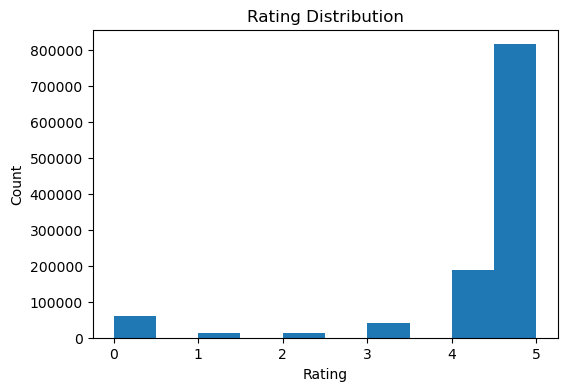

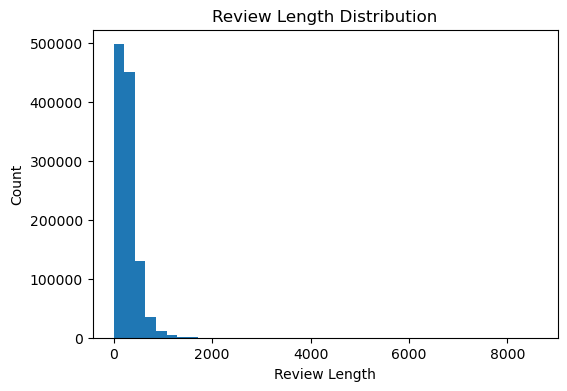


Average review length: 278.36793018517847


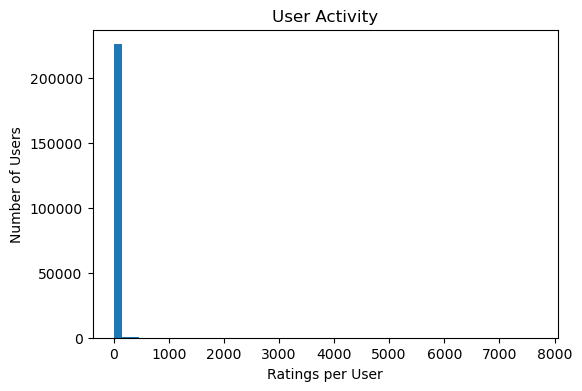

Average ratings per user: 4.997868208500684


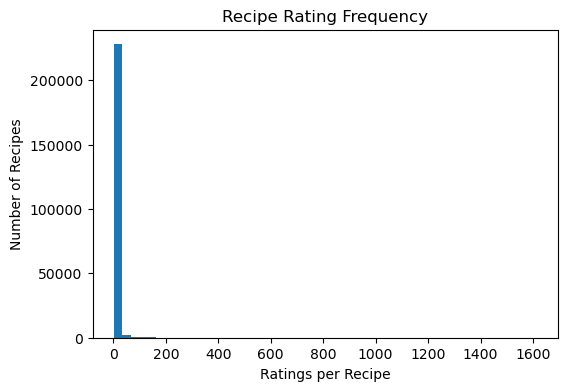

Average ratings per recipe: 4.888541122532238

Matrix sparsity: 1.0000


In [35]:
# EDA

import matplotlib.pyplot as plt

# Basic summaries
print("Interactions shape:", interactions.shape)
print("Recipes shape:", recipe_info.shape)

print("\nInteractions preview:")
display(interactions.head())

print("\nRecipes preview:")
display(recipe_info.head())

# Missing values
print("\nMissing values (interactions):")
display(interactions.isna().sum())

print("\nMissing values (recipes):")
display(recipe_info.isna().sum())

# Rating distribution
plt.figure(figsize=(6,4))
interactions['rating'].hist(bins=10)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.grid(False)
plt.show()

# Reviews: length distribution
interactions['review_length'] = interactions['review'].fillna("").apply(len)

plt.figure(figsize=(6,4))
interactions['review_length'].hist(bins=40)
plt.xlabel("Review Length")
plt.ylabel("Count")
plt.title("Review Length Distribution")
plt.grid(False)
plt.show()

print("\nAverage review length:", interactions['review_length'].mean())

# User activity
user_counts = interactions['user_id'].value_counts()

plt.figure(figsize=(6,4))
user_counts.hist(bins=50)
plt.xlabel("Ratings per User")
plt.ylabel("Number of Users")
plt.title("User Activity")
plt.grid(False)
plt.show()

print("Average ratings per user:", user_counts.mean())

# Recipe activity
recipe_counts = interactions['recipe_id'].value_counts()

plt.figure(figsize=(6,4))
recipe_counts.hist(bins=50)
plt.xlabel("Ratings per Recipe")
plt.ylabel("Number of Recipes")
plt.title("Recipe Rating Frequency")
plt.grid(False)
plt.show()

print("Average ratings per recipe:", recipe_counts.mean())

# Sparsity of the matrix
n_users = interactions['user_id'].nunique()
n_recipes = interactions['recipe_id'].nunique()
n_interactions = len(interactions)

sparsity = 1 - (n_interactions / (n_users * n_recipes))
print(f"\nMatrix sparsity: {sparsity:.4f}")


In [11]:
# Separating interactions
interactions_train_only = interactions.merge(
    train[["user_id", "recipe_id"]],
    on=["user_id", "recipe_id"],
    how="inner"
)

interactions_test_only = interactions.merge(
    test[["user_id", "recipe_id"]],
    on=["user_id", "recipe_id"],
    how="inner"
)

interactions_valid_only = interactions.merge(
    valid[["user_id", "recipe_id"]],
    on=["user_id", "recipe_id"],
    how="inner"
)

In [12]:
# Extracting recipe reviews and cleaning
reviews = interactions_train_only['review']
reviews = reviews.fillna('')
reviews = reviews.tolist()

In [13]:
# Using TFIDF for recipe reviews
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.5)
X = vectorizer.fit_transform(reviews)

In [14]:
y = interactions_train_only['rating'].tolist()

In [15]:
# Check the structure of recipes DataFrame
print("Recipes columns:", recipes.columns.tolist())
print("\nRecipes shape:", recipes.shape)
print("\nFirst few rows:")
recipes.head()

Recipes columns: ['id', 'i', 'name_tokens', 'ingredient_tokens', 'steps_tokens', 'techniques', 'calorie_level', 'ingredient_ids']

Recipes shape: (178265, 8)

First few rows:


,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


In [16]:
# feature matrix for recipes, sparse vector for ingredients and nutrition

from scipy.sparse import csr_matrix, hstack
import ast

# Check if ingredient_ids needs parsing or is already a list
if isinstance(recipes['ingredient_ids'].iloc[0], str):
    # Parse ingredient_ids from strings to actual lists
    recipes['ingredient_ids'] = recipes['ingredient_ids'].apply(ast.literal_eval)

max_ingr = max([max(ids) for ids in recipes['ingredient_ids'] if len(ids) > 0]) + 1
rows = []
cols = []
data = []

for i, ingr_list in enumerate(recipes['ingredient_ids']):
    for ingr in ingr_list:
        rows.append(i)
        cols.append(ingr)
        data.append(1)

ingredient_matrix = csr_matrix((data, (rows, cols)), shape=(len(recipes), max_ingr))

# Convert calorie_level to numeric and reshape
calorie_features = np.array(recipes['calorie_level']).reshape(-1, 1)
calorie_matrix = csr_matrix(calorie_features)

recipe_features = hstack([ingredient_matrix, calorie_matrix])

In [17]:
#Align interactions with recipe feature rows

recipe_id_to_row = {rid: idx for idx, rid in recipes['id'].items()}

recipe_rows = interactions_train_only['recipe_id'].map(recipe_id_to_row)
valid_mask = recipe_rows.notna()

# Filter interactions to only keep recipes that exist in pp recipes
interactions_train_only = interactions_train_only[valid_mask]
recipe_rows = recipe_rows[valid_mask].astype(int)

# Re-extract reviews and rebuild TF-IDF matrix after filtering
reviews = interactions_train_only['review'].fillna('').tolist()
vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.5)
X = vectorizer.fit_transform(reviews)

# Extract recipe feature rows
R = recipe_features[recipe_rows]

In [18]:
# X is TF-IDF matrix 
# R is recipe metadata matrix

X_full = hstack([X, R])
y = interactions_train_only['rating'].values

In [19]:
#Train ridge regression mode

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0, solver="lsqr")
model.fit(X_train, y_train)

preds = model.predict(X_test)
print("MAE:", np.mean(np.abs(preds - y_test)))


MAE: 0.4742648159887846


In [20]:
# Check if user 2046 exists and see what recipes they've reviewed
user_interactions = interactions_train_only[interactions_train_only['user_id'] == 2046]
print(f"User 2046 has {len(user_interactions)} interactions")
if len(user_interactions) > 0:
    print("Sample interactions:")
    print(user_interactions[['recipe_id', 'rating']].head())
else:
    print("User 2046 not found. Let's find a valid user:")
    sample_user = interactions_train_only['user_id'].iloc[0]
    print(f"Using user {sample_user} instead")

User 2046 has 4 interactions
Sample interactions:
        recipe_id  rating
179751       4684       5
350768        517       5
405514       3431       5
533380      13307       5


In [21]:
from scipy.sparse import hstack

def ingredient_similarity_to_user(user_id, recipe_id):
    # Get all recipes the user rated
    user_rids = interactions_train_only[interactions_train_only['user_id'] == user_id]['recipe_id']

    # Convert to feature rows
    user_rows = [recipe_id_to_row[r] for r in user_rids if r in recipe_id_to_row]
    user_feats = recipe_features[user_rows]

    # Candidate recipe ingredients
    r_row = recipe_id_to_row[recipe_id]
    r_vec = recipe_features[r_row]

    # Mean user ingredient vector
    user_mean_vec = user_feats.mean(axis=0)

    # Jaccard similarity components
    intersect = np.minimum(r_vec.toarray(), user_mean_vec.toarray()).sum()
    union = np.maximum(r_vec.toarray(), user_mean_vec.toarray()).sum()

    if union == 0:
        return 0
    return intersect / union

In [22]:
def recommend_recipes_for_user(user_id, top_k=10, preference=None, verbose=True):
    import pandas as pd

    # -------------------------------------
    # 0. Find user & candidate recipes
    # -------------------------------------
    user_interactions = interactions_train_only[interactions_train_only['user_id'] == user_id]

    if len(user_interactions) == 0:
        if verbose:
            print(f"User {user_id} not found")
        return pd.DataFrame(columns=["id", "pred_rating", "calorie_level"])

    reviewed = set(user_interactions['recipe_id'])
    candidates = recipes[~recipes['id'].isin(reviewed)].copy()

    if len(candidates) == 0:
        return pd.DataFrame(columns=["id", "pred_rating", "calorie_level"])


    # -------------------------------------
    # 1. Build user ingredient profile
    # -------------------------------------
    user_rids = user_interactions['recipe_id']
    user_rows = [recipe_id_to_row[r] for r in user_rids if r in recipe_id_to_row]

    if len(user_rows) > 0:
        user_ing_matrix = recipe_features[user_rows]
        user_ing_profile = np.asarray(user_ing_matrix.mean(axis=0)).ravel()
    else:
        user_ing_profile = np.zeros(ingredient_matrix.shape[1])


    # -------------------------------------
    # 2. Build model feature input
    # (must EXACTLY match training shape!)
    # -------------------------------------
    cand_reviews = [''] * len(candidates)
    X_cand = vectorizer.transform(cand_reviews)

    cand_rows = [recipe_id_to_row[rid] for rid in candidates['id']]
    R_cand = recipe_features[cand_rows]

    full_cand = hstack([X_cand, R_cand])  # EXACTLY the same as training

    # -------------------------------------
    # 3. Predict base scores
    # -------------------------------------
    scores = model.predict(full_cand)
    scores = np.clip(scores, 1.0, 5.0)

    candidates["pred_rating"] = scores


    # -------------------------------------
    # 4. Compute personalization signals
    # (done AFTER prediction → no dimension mismatch)
    # -------------------------------------
    ingredient_sims = []
    for rid in candidates['id']:
        rvec = recipe_features[recipe_id_to_row[rid]].toarray().ravel()
        inter = np.minimum(rvec, user_ing_profile).sum()
        uni = np.maximum(rvec, user_ing_profile).sum()
        ing_sim = inter / uni if uni > 0 else 0.0
        ingredient_sims.append(ing_sim)

    ingredient_sims = np.array(ingredient_sims)


    # -------------------------------------
    # 5. Apply preference logic
    # -------------------------------------
    if preference == "ingredients":
        # strong personalization
        rerank_score = 2 * ingredient_sims + 0.1 * candidates["pred_rating"]
        candidates["final_score"] = rerank_score
        recommendations = candidates.sort_values("final_score", ascending=False).head(top_k)

    elif preference == "low_calorie":
        scores[candidates["calorie_level"] <= 1] *= 1.15
        scores[candidates["calorie_level"] > 1] *= 0.85
        candidates["pred_rating"] = scores
        recommendations = candidates.sort_values("pred_rating", ascending=False).head(top_k)

    elif preference == "high_calorie":
        scores[candidates["calorie_level"] >= 2] *= 1.15
        scores[candidates["calorie_level"] < 2] *= 0.85
        candidates["pred_rating"] = scores
        recommendations = candidates.sort_values("pred_rating", ascending=False).head(top_k)

    else:
        # default → lightly mix personalization
        candidates["final_score"] = (
            candidates["pred_rating"] + 2.0 * ingredient_sims
        )
        recommendations = candidates.sort_values("final_score", ascending=False).head(top_k)


    # -------------------------------------
    # 6. Verbose print
    # -------------------------------------
    if verbose:
        print(f"\nTop {top_k} for user {user_id} (pref={preference}):")
        print("="*60)
        for i, (_, row) in enumerate(recommendations.iterrows(), 1):
            ing_sim = ingredient_sims[candidates.index.get_loc(row.name)]
            print(f"{i}. Recipe {row['id']} | Rating {row['pred_rating']:.2f}")
            print(f"   Ingredient similarity: {ing_sim:.3f}")
            print(f"   Calories: {row['calorie_level']}")
            print("-"*40)

    return recommendations[["id", "pred_rating", "calorie_level"]]


In [23]:


uid = interactions_test_only['user_id'].sample(1).iloc[0]
recommend_recipes_for_user(uid, top_k=10)

uid = interactions_test_only['user_id'].sample(1).iloc[0]
recommend_recipes_for_user(uid, top_k=10)



Top 10 for user 375742 (pref=None):
1. Recipe 134668 | Rating 5.00
   Ingredient similarity: 0.129
   Calories: 0
----------------------------------------
2. Recipe 368016 | Rating 4.98
   Ingredient similarity: 0.105
   Calories: 1
----------------------------------------
3. Recipe 70840 | Rating 4.94
   Ingredient similarity: 0.121
   Calories: 1
----------------------------------------
4. Recipe 114461 | Rating 4.86
   Ingredient similarity: 0.156
   Calories: 1
----------------------------------------
5. Recipe 158940 | Rating 4.81
   Ingredient similarity: 0.175
   Calories: 0
----------------------------------------
6. Recipe 149561 | Rating 4.73
   Ingredient similarity: 0.210
   Calories: 2
----------------------------------------
7. Recipe 142709 | Rating 5.00
   Ingredient similarity: 0.061
   Calories: 2
----------------------------------------
8. Recipe 273252 | Rating 4.96
   Ingredient similarity: 0.079
   Calories: 2
----------------------------------------
9. Recipe 14

,id,pred_rating,calorie_level
161157,142709,5.000000,2
94424,445797,5.000000,2
122263,70840,4.937878,1
89722,368016,4.975545,1
114679,273252,4.963620,2
68583,134668,5.000000,0
167663,422315,5.000000,1
123197,514885,5.000000,0
164732,81058,4.846807,2
147925,434426,4.865753,1


## MAE Graphs for General Performance Testing

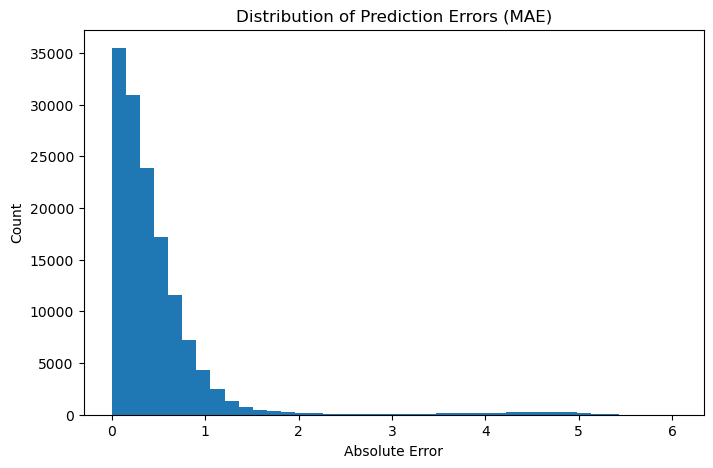

In [24]:
import matplotlib.pyplot as plt
import numpy as np

errors = np.abs(preds - y_test)

plt.figure(figsize=(8,5))
plt.hist(errors, bins=40)
plt.title("Distribution of Prediction Errors (MAE)")
plt.xlabel("Absolute Error")
plt.ylabel("Count")
plt.show()


## Preference Impact Graph

## User Taste Map via PCA

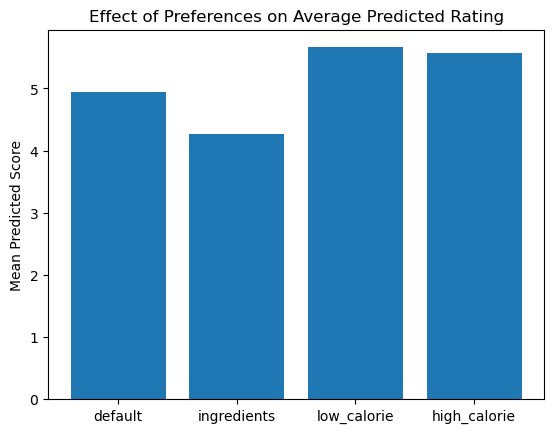

In [25]:
prefs = ["default", "ingredients", "low_calorie", "high_calorie"]
scores = []

uid = interactions_train_only['user_id'].iloc[0]

for p in prefs:
    if p == "default":
        r = recommend_recipes_for_user(uid, top_k=20, verbose=False)
    else:
        r = recommend_recipes_for_user(uid, top_k=20, preference=p, verbose=False)
    scores.append(r['pred_rating'].mean())

plt.bar(prefs, scores)
plt.title("Effect of Preferences on Average Predicted Rating")
plt.ylabel("Mean Predicted Score")
plt.show()


## Ingredient Diversity vs Calorie Level

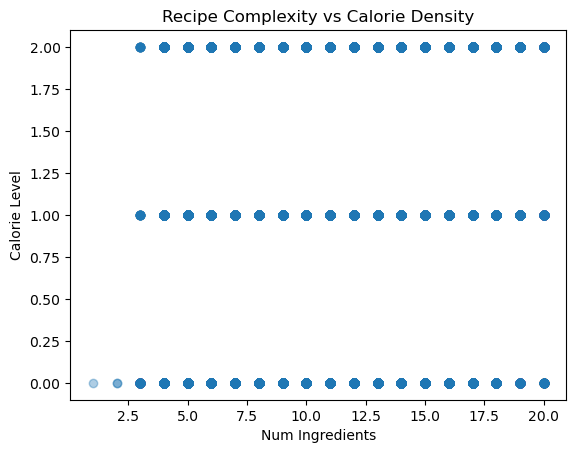

In [26]:
import matplotlib.pyplot as plt

x = recipes['ingredient_ids'].apply(len)
y = recipes['calorie_level']

plt.scatter(x, y, alpha=0.2)
plt.xlabel("Num Ingredients")
plt.ylabel("Calorie Level")
plt.title("Recipe Complexity vs Calorie Density")
plt.show()


Using user: 424680

Ingredient Diversity Results:
----------------------------
Default model:          143 distinct ingredients
Ingredient preference:  12 distinct ingredients


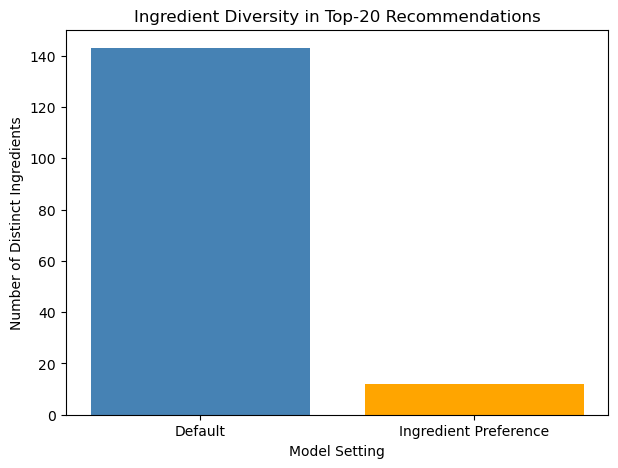

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 1. Safe ingredient diversity function
# ---------------------------------------------------------
def ingredient_diversity(rec_df):
    if rec_df is None or len(rec_df) == 0:
        return 0

    # map recipe IDs → feature rows
    rows = [recipe_id_to_row[r] for r in rec_df['id']]
    feats = recipe_features[rows]      # sparse matrix slice

    summed = feats.sum(axis=0)         # sum ingredients across recipes
    arr = np.asarray(summed).ravel()   # convert to ndarray
    return np.count_nonzero(arr)       # count distinct ingredients
        

# ---------------------------------------------------------
# 2. Choose a strong user (lots of interactions)
# ---------------------------------------------------------
uid = interactions_train_only['user_id'].value_counts().idxmax()
print("Using user:", uid)

# ---------------------------------------------------------
# 3. Get recommendations
# ---------------------------------------------------------
recs_default = recommend_recipes_for_user(uid, top_k=20, verbose=False)
recs_ing_pref = recommend_recipes_for_user(uid, top_k=20, preference="ingredients", verbose=False)

# ---------------------------------------------------------
# 4. Compute ingredient diversity
# ---------------------------------------------------------
div_default = ingredient_diversity(recs_default)
div_ing = ingredient_diversity(recs_ing_pref)

print("\nIngredient Diversity Results:")
print("----------------------------")
print(f"Default model:          {div_default} distinct ingredients")
print(f"Ingredient preference:  {div_ing} distinct ingredients")

# ---------------------------------------------------------
# 5. Plot comparison
# ---------------------------------------------------------
labels = ["Default", "Ingredient Preference"]
values = [div_default, div_ing]

plt.figure(figsize=(7,5))
plt.bar(labels, values, color=["steelblue", "orange"])
plt.title("Ingredient Diversity in Top-20 Recommendations")
plt.ylabel("Number of Distinct Ingredients")
plt.xlabel("Model Setting")
plt.show()


In [28]:
# Baseline

from sklearn.metrics import mean_squared_error, mean_absolute_error

ratingMean = train['rating'].mean()

preds = []
truths = []

val_df = valid[:1000]

for _, row in val_df.iterrows():
    user = row["user_id"]
    recipe = row["recipe_id"]
    true_rating = row["rating"]

    pred_rating = ratingMean

    preds.append(pred_rating)
    truths.append(true_rating)

# Metrics
rmse = np.sqrt(mean_squared_error(truths, preds))
mae = mean_absolute_error(truths, preds)

# Running the validation
print(rmse)
print(mae)

1.1882820994672145
0.7809601789094592


In [29]:
# Validation testing

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def validate_recommender(val_df, verbose=True):
    preds = []
    truths = []

    for _, row in val_df.iterrows():
        user = row["user_id"]
        recipe = row["recipe_id"]
        true_rating = row["rating"]

        # Run recommender for this user
        recs = recommend_recipes_for_user(user, top_k=len(recipes), verbose=False)

        # If recipe not recommended, then skip (user may have already rated it)
        if recipe not in set(recs["id"]):
            continue

        pred_rating = float(recs[recs["id"] == recipe]["pred_rating"].iloc[0])

        preds.append(pred_rating)
        truths.append(true_rating)

    # Metrics
    rmse = np.sqrt(mean_squared_error(truths, preds))
    mae = mean_absolute_error(truths, preds)

    if verbose:
        print("Validation RMSE:", rmse)
        print("Validation MAE :", mae)

    return np.array(preds), np.array(truths), rmse, mae


# Running the validation
preds, truths, rmse, mae = validate_recommender(valid[:1000])

Validation RMSE: 0.7431999020755662
Validation MAE : 0.6450774401575265


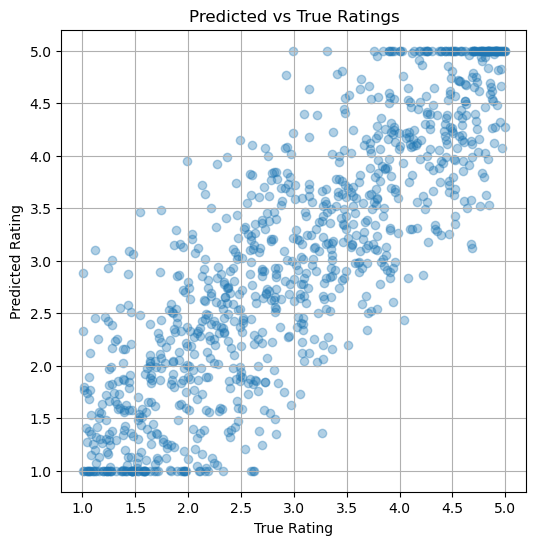

In [33]:
plt.figure(figsize=(6,6))
plt.scatter(truths, preds, alpha=0.35)
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.title("Predicted vs True Ratings")
plt.grid(True)
plt.show()

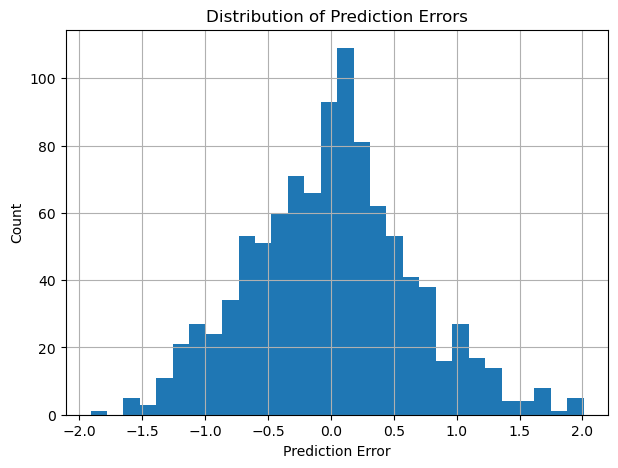

In [34]:
errors = preds - truths

plt.figure(figsize=(7,5))
plt.hist(errors, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("Distribution of Prediction Errors")
plt.grid(True)
plt.show()